In [2]:
%pip install torch


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/68/49/5e1c771294407bb25e6dbcf169aef5cffefcddf27b0176125a9b0af06a1e/torchvision-0.17.2-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/3a/d0/edc009c27b406c4f9cbc79274d6e46d634d139075492ad055e3d68445925/numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 684.8 kB/s eta 0:00:00 kB/s eta 0:00:01
  Obtaining dependency information for pillow!=8.3.*,>=5.3.0 from https://files.pythonhosted.org/packages/66/9c/2e1877630eb298bbfd23f90deeec0a3f682a4163d5ca9f178937de57346c/pillow-10.2.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 3.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━

In [5]:
%pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/ef/1d/bf1d78126c3d106100232d3a18b7f3732e7dc3b71ee38ab735e4064b19cc/matplotlib-3.8.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/e2/83/29a63bbc72839cc6b24b5a0e3d004d4ed4e8439f26460ad9a34e39251904/contourpy-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/86/d0/06de6c883a2511c35bba400d0f6e42b8da0ff34123586cfb11213c9357df/fonttools-4.50.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import torch
import random 
import os

In [2]:
%matplotlib inline

torch.manual_seed(0)

In [3]:
print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.2.2+cu121


In [4]:
%ls "./dataset/"

test/  train/  xztwjmktrg-3/


In [89]:
class_names = ['covid', 'normal', 'pneumonia-viral', 'pneumonia-bacterial']

root_dir = 'dataset'
# source_dirs = ['covid', 'normal', 'pneumonia-viral', 'pneumonia-bacterial']
source_dirs = ['COVID-19', 'Normal', 'Pneumonia-Viral', 'Pneumonia-Bacterial']


if os.path.isdir(os.path.join(root_dir, source_dirs[0])):
    os.mkdir(os.path.join(root_dir, 'test'))
    
    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))
 
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('jpg')]

        if len(images) >= 30:  # Check if there are at least 30 images to sample from
            selected_images = random.sample(images, 30)
            for image in selected_images:
                source_path = os.path.join(root_dir, c, image)
                target_path = os.path.join(root_dir, 'test', c, image)
                shutil.move(source_path, target_path)
        else:
            print(f"Not enough images in class {c} to sample from.")

In [5]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('jpg')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['covid', 'normal', 'pneumonia-viral', 'pneumonia-bacterial']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index

In [6]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
train_dirs = {
    'covid': 'dataset/train/covid',
    'normal': 'dataset/train/normal',
    'pneumonia-viral': 'dataset/train/pneumonia-viral',
    'pneumonia-bacterial': 'dataset/train/pneumonia-bacterial',
}

In [11]:
train_dataset = ChestXRayDataset(image_dirs=train_dirs, transform=train_transform)

Found 1251 covid examples
Found 3241 normal examples
Found 1626 pneumonia-viral examples
Found 2971 pneumonia-bacterial examples


In [12]:
test_dirs = {
    'covid': 'dataset/test/covid',
    'normal': 'dataset/test/normal',
    'pneumonia-viral': 'dataset/test/pneumonia-viral',
    'pneumonia-bacterial': 'dataset/test/pneumonia-bacterial',
}

In [13]:
test_dataset = ChestXRayDataset(image_dirs=test_dirs, transform=test_transform)

Found 30 covid examples
Found 30 normal examples
Found 30 pneumonia-viral examples
Found 30 pneumonia-bacterial examples


In [14]:
batch_size = 32

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 285
Number of test batches 4


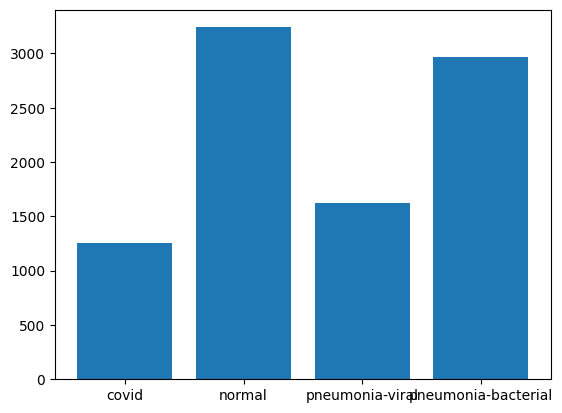

In [20]:
class_names = train_dataset.class_names
image_count = {}

for i in class_names:
    image_count[i] = len(os.listdir(f'./dataset/train/{i}'))
    
fig1, ax1 = plt.subplots()
ax1.bar(image_count.keys(), image_count.values())
plt.show()


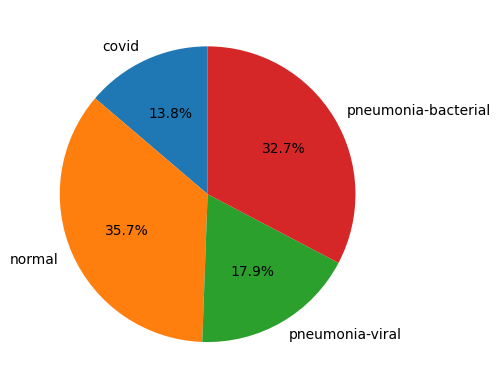

In [21]:
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(), labels=image_count.keys(), autopct='%1.1f%%', startangle=90)
plt.show()

/tmp/ipykernel_96829/12989017.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


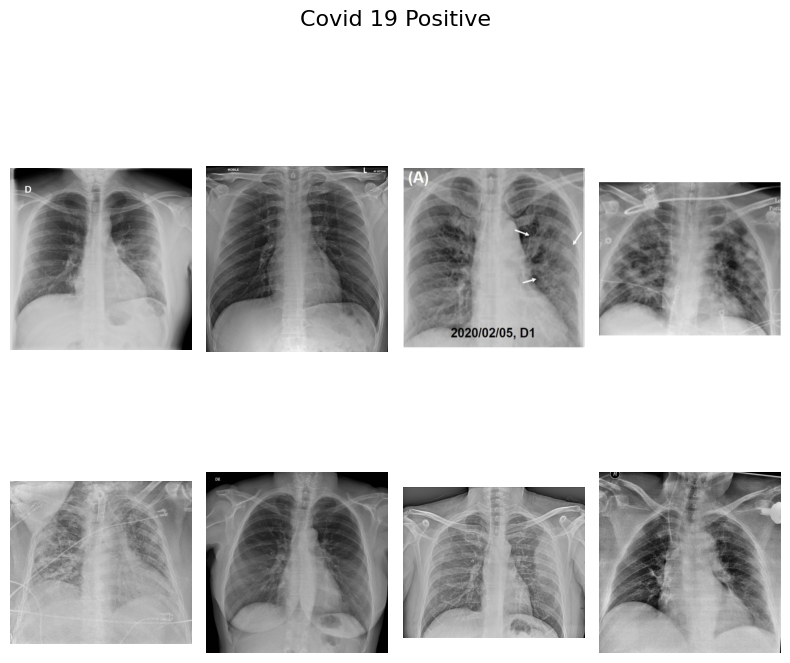

In [22]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Covid 19 Positive', fontsize=16)
image_paths = os.listdir('dataset/train/covid')
random.shuffle(image_paths)

for i, image in enumerate(image_paths[:8]):
    im = Image.open(f'dataset/train/covid/{image}')
    plt.subplot(2, 4, i + 1)
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()
fig.show()

/tmp/ipykernel_96829/3306457349.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


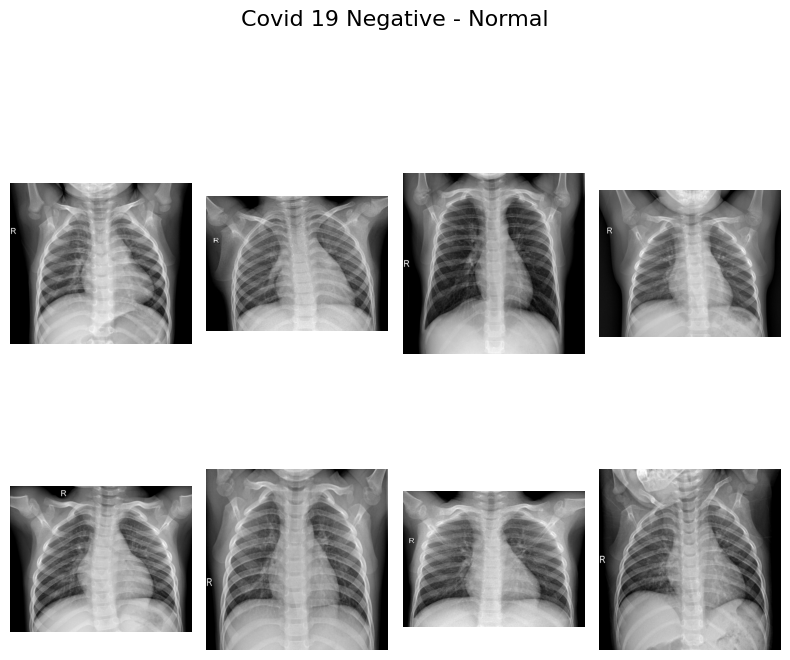

In [25]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Covid 19 Negative - Normal', fontsize=16)
image_paths = os.listdir('dataset/train/normal')
random.shuffle(image_paths)

for i, image in enumerate(image_paths[:8]):
    im = Image.open(f'dataset/train/normal/{image}')
    plt.subplot(2, 4, i + 1)
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()
fig.show()

In [26]:

import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [27]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [28]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size

In [29]:
trainloader, valloader, dataset_size = load_split_train_test('dataset/train/', .2)

In [30]:
dataloaders = {"train":trainloader, "val":valloader}

In [31]:
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['covid', 'normal', 'pneumonia-bacterial', 'pneumonia-viral']


In [32]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [33]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [34]:
out = torchvision.utils.make_grid(inputs)

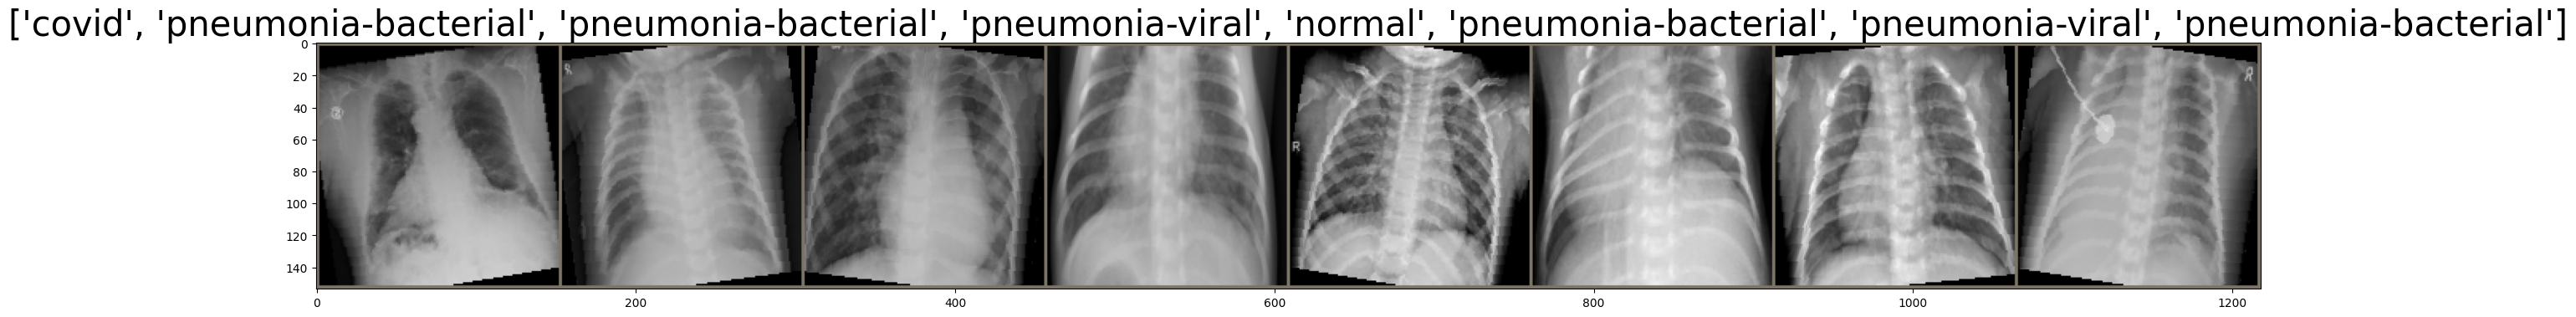

In [35]:
imshow(out, title=[class_names[x] for x in classes])

In [36]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on CPU... May the force be with you...


In [37]:
torch.cuda.empty_cache()

In [38]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

In [39]:
model = CNN_Model(pretrained=True)

/mnt/code/frog/COVID-19-x-ray/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/code/frog/COVID-19-x-ray/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
criterion = nn.CrossEntropyLoss() 

In [41]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [42]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning 

In [43]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6957956


In [44]:
%pip install tqdm


Note: you may need to restart the kernel to use updated packages.


In [45]:
import time
import copy
import tqdm.notebook as tqdm

In [47]:
# %pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 2.5 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [48]:
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2


In [49]:
# %pip install ipywidgets widgetsnbextension pandas-profiling
# %pip install --upgrade tqdm jupyter ipywidgets
# %pip install -U scikit-learn
# %pip install --upgrade pip

In [50]:
%jupyter nbextension enable --py widgetsnbextension

UsageError: Line magic function `%jupyter` not found.


In [51]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [52]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [53]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


Epoch 1/10
----------


train:   0%|          | 0/909 [00:00<?, ?it/s]

train Loss: 0.8859 | train Accuracy: 0.6608


val:   0%|          | 0/228 [00:00<?, ?it/s]

In [ ]:
visualize_model(base_model)
plt.show()

In [ ]:
TEST_DATA_PATH = '/dataset/test/'


test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [ ]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [ ]:
print(classification_report(y_true_list, y_pred_list))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [ ]:
torch.save(base_model.state_dict(), './best_model.pth')

## Inference

In [ ]:
inf_model = CNN_Model(pretrained=False)
inf_model.to(torch.device('cpu'))
inf_model.load_state_dict(torch.load('./best_model.pth', map_location='cpu'))
inf_model.eval()
print('Inference Model Loaded on CPU')

In [ ]:
import cv2
from torch.autograd import Variable

In [ ]:
def predict(img_path):
    image = Image.open(img_path)
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    # print(input.shape)
    input = input.to(torch.device('cpu'))
    out = inf_model(input)
    _, preds = torch.max(out, 1)
    idx = preds.cpu().numpy()[0]
    pred_class = class_names[idx]
    score = out[0][0].item()
    plt.imshow(np.array(image))
    print("Predicted: {}".format(pred_class))

In [ ]:
predict('./dataset/test/covid/COVID-19 (869).jpg')